<h1 align="center"> Image Captioning </h1>

In this notebook you will teach a network to do image captioning
![img](https://media.licdn.com/dms/image/C4D12AQH-T7BYWr9clg/article-inline_image-shrink_1500_2232/0?e=2120536800&v=alpha&t=RrGrsyl8QPtDQjdKKw6VpEbJrTq1Dnigk89_t9vhbfw)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

In [37]:
!pip install https://github.com/rsennrich/subword-nmt/archive/package.zip

  Running setup.py bdist_wheel for subword-nmt ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-pjupd5zx/wheels/5a/9a/67/279dc97bff69606b6817f2832d3e4b2c5dd71e34d7fd675dd2
Successfully built subword-nmt
torchvision 0.2.0 requires pillow>=4.1.1, which is not installed.


In [1]:
# Please eithrer download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually.

### Data preprocessing

In [1]:
%%time
# Read Dataset
import itertools
import numpy as np
import json
from subword_nmt.apply_bpe import BPE

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 220 ms, sys: 396 ms, total: 616 ms
Wall time: 288 ms


In [2]:
with open("text.txt", "w") as fout:
    for caption in itertools.chain(*captions):
        print(caption, file=fout)

In [3]:
!subword-nmt learn-bpe -s 1000 < text.txt > bpe_codes.txt

In [4]:
!head bpe_codes.txt

#version: 0.2
i n
in g</w>
t h
i t
a n
o n</w>
a r
i n</w>
o f</w>


In [5]:
bpe = BPE(open("bpe_codes.txt"))

In [6]:
# flag controlling whether or not byte pair encoding is applied
APPLY_BPE = True

### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [7]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [8]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i]
        if APPLY_BPE:
            sentence = bpe.segment(sentence)
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [9]:
# Build a Vocabulary
import itertools
from collections import Counter
word_counts = Counter()

#Compute word frequencies for each word in captions. See code above for data structure
for sentence in itertools.chain(*captions):
    word_counts.update(sentence)

In [10]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
occurance_threshold = 0 if APPLY_BPE else 5
print(occurance_threshold)
vocab += [k for k, v in word_counts.items() if v >= occurance_threshold if k not in vocab]
n_tokens = len(vocab)

word_to_index = {w: i for i, w in enumerate(vocab)}

0


In [11]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [12]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[  1,  34, 341, 184,   8, 208,  17,  34, 790, 204,  15,   2,   3,
          3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3],
       [  1,  34, 341,  66,  22,  34, 790, 204,   2,   3,   3,   3,   3,
          3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3],
       [  1,  34, 341,  54,  22, 680, 268,  48, 666, 204,   2,   3,   3,
          3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3],
       [  1,  58, 150, 341,  54,  66,  22, 666, 113,  39,  97,  15,   2,
          3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3],
       [  1,  34, 341,  66,  22,  34, 790, 158,  72,  58, 358, 359, 296,
        216, 291,  34, 146, 501,  21,  48,  58, 880,  15,   2]],
      dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [13]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [14]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, recurrent_units=256, cnn_feature_size=2048):
        super().__init__()
        self.recurrent_units = recurrent_units
        self.num_layers = 3
        
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, self.num_layers * recurrent_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, self.num_layers * recurrent_units)
        
        self.embedding = nn.Embedding(n_tokens, emb_size, padding_idx=pad_ix)
        self.rnn = nn.LSTM(num_layers=self.num_layers, input_size=emb_size, hidden_size=recurrent_units, batch_first=True)
        self.projections = nn.Linear(recurrent_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix, prev_hidden_state=None):
        """ 
        Apply the network in training mode. 
        :param image_vectors: a Variable containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: a Variable containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        if prev_hidden_state is None:
            batch_size = image_vectors.shape[0]
            initial_cell = (self.cnn_to_c0(image_vectors).view(batch_size, self.num_layers, self.recurrent_units)
                            .transpose(0, 1).contiguous())
            initial_hid = (self.cnn_to_h0(image_vectors).view(batch_size, self.num_layers, self.recurrent_units)
                           .transpose(0, 1).contiguous())
            prev_hidden_state = (initial_cell, initial_hid)

        captions_emb = self.embedding(captions_ix)
        rnn_out, next_hidden_state = self.rnn(captions_emb, prev_hidden_state)
        logits = self.projections(rnn_out)
        
        return logits, next_hidden_state
    

class CaptionNetGRU(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, recurrent_units=256, cnn_feature_size=2048):
        super().__init__()
        self.recurrent_units = recurrent_units
        self.num_layers = 3
        
        self.cnn_to_hidden = nn.Linear(cnn_feature_size, self.num_layers * recurrent_units)
        self.embedding = nn.Embedding(n_tokens, emb_size, padding_idx=pad_ix)
        self.rnn = nn.GRU(num_layers=self.num_layers, input_size=emb_size, hidden_size=recurrent_units, batch_first=True)
        self.projections = nn.Linear(recurrent_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix, prev_hidden_state=None):
        """ 
        Apply the network in training mode. 
        :param image_vectors: a Variable containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: a Variable containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        if prev_hidden_state is None:
            batch_size = image_vectors.shape[0]
            prev_hidden_state = (self.cnn_to_hidden(image_vectors).view(batch_size, self.num_layers, self.recurrent_units)
                                 .transpose(0, 1).contiguous())

        captions_emb = self.embedding(captions_ix)
        rnn_out, next_hidden_state = self.rnn(captions_emb, prev_hidden_state)
        logits = self.projections(rnn_out)
        
        return logits, next_hidden_state


In [15]:
network = CaptionNet(n_tokens, emb_size=256, recurrent_units=256)

In [16]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: a Variable containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: a Variable containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones. Scalar float Variable
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next, _ = network.forward(image_vectors, captions_ix_inp)
    
    mask = (captions_ix_next != pad_ix).float()
    
    loglikes = F.log_softmax(logits_for_next, dim=-1).transpose(1, 2)
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    
    loss = (mask * F.nll_loss(loglikes, captions_ix_next)).sum() / mask.sum()
    
    return loss

Create ~~adam~~ your favorite optimizer for the network.

In [17]:
network.cuda()
opt = torch.optim.Adam(network.parameters(), lr=1e-3)

# Training

* First implement the batch generator
* Than train the network as usual

In [18]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [19]:
from random import choice


def iterate_minibathes(img_codes, captions, batch_size, caption_strategy='sample', volatile=False):
    if caption_strategy not in ['sample', 'pass']:
        raise ValueError("Caption strategy should be either 'sample' or 'pass'")
    indices = np.random.permutation(np.arange(len(img_codes)))
    for i in range(0, len(indices), batch_size):
        indices_batch = indices[i:i+batch_size]
        images_batch = img_codes[indices_batch]
        if caption_strategy == 'sample':
            captions_batch = list(map(choice, captions[indices_batch]))
            captions_batch = Variable(torch.LongTensor(as_matrix(captions_batch)), volatile=volatile).cuda()
        else:
            captions_batch = captions[indices_batch]

        yield Variable(torch.FloatTensor(images_batch), volatile=volatile).cuda(), captions_batch


def greedy_decode(img_codes_batch, max_len=100):
    batch_size = img_codes_batch.shape[0]
    start_index = word_to_index["#START#"]
    caption_prefix_encoded = [Variable(torch.LongTensor([[start_index]] * batch_size), volatile=True).cuda()]
    hidden_state = None
    for _ in range(max_len - 1):
        logits, hidden_state = network(img_codes_batch, caption_prefix_encoded[-1], hidden_state)
        next_words = torch.max(logits, -1)[1]
        caption_prefix_encoded.append(next_words)
    caption_prefix_encoded = torch.cat(caption_prefix_encoded, 1).data.cpu().numpy()
    sentences = []
    for i in range(batch_size):
        sentence = []
        for j in range(max_len):
            sentence.append(vocab[caption_prefix_encoded[i, j]])
            if caption_prefix_encoded[i, j] == eos_ix:
                break
        sentences.append(sentence)
    return sentences

def join_bpe(subword_units):
    return " ".join(subword_units).replace("@@ ", "")

def compute_corpus_bleu(list_of_references, hypotheses):
    if APPLY_BPE:
        hypotheses = [join_bpe(hypothesis).split() for hypothesis in hypotheses]
        list_of_references = [[join_bpe(reference).split() for reference in references] for references in list_of_references]
    return nltk.translate.bleu_score.corpus_bleu(list_of_references, hypotheses)

In [20]:
next(iterate_minibathes(img_codes, captions, 1, caption_strategy='pass'))

(Variable containing:
  1.3940  0.1250  0.1980  ...   1.0447  0.4906  0.0656
 [torch.cuda.FloatTensor of size 1x2048 (GPU 0)],
 array([[list(['#START#', 'two', 'zebras', 'standing', 'by', 'a', 'car', 'in', 'front', 'of', 'some', 'trees', '#END#']),
         list(['#START#', 'there', 'are', 'two', 'zebras', 'h@@', 'ere', 'and', 'there', 'is', 'a', 'car', 'in', 'the', 'back', 'ground', '#END#']),
         list(['#START#', 'two', 'zebras', 'with', 'trees', 'and', 'a', 've@@', 'hi@@', 'c@@', 'le', 'behind', 'them', '.', '#END#']),
         list(['#START#', 'a', 'group', 'of', 'zebras', 'standing', 'behind', 'a', 'car', '.', '#END#']),
         list(['#START#', 'two', 'zebras', 'a', 'black', 'car', 'and', 'some', 'trees', '#END#'])]],
       dtype=object))

In [21]:
for batch in iterate_minibathes(img_codes, captions, 128):
    print(greedy_decode(batch[0], max_len=3)[0])
    break

['#START#', 'track', 'track']


### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [22]:
import nltk
import time

In [23]:
batch_size = 128  # adjust me
n_epochs = 100  # adjust me

In [24]:
for epoch in range(n_epochs):
    start = time.time()
    train_losses = []
    network.train(True)
    for batch in iterate_minibathes(train_img_codes, train_captions, batch_size):
        loss = compute_loss(network, *batch)
        opt.zero_grad()
        loss.backward()
        opt.step()
        train_losses.append(loss.data.cpu().numpy()[0])
    train_loss = np.mean(train_losses)
    
    val_losses = []
    network.train(False)
    for batch in iterate_minibathes(val_img_codes, val_captions, batch_size, volatile=True):
        loss = compute_loss(network, *batch)
        val_losses.append(loss.data.cpu().numpy()[0])
    val_loss = np.mean(val_losses)
    
    bleu_scores = []
    for batch in iterate_minibathes(val_img_codes, val_captions, batch_size, caption_strategy='pass', volatile=True):
        hypotheses = greedy_decode(batch[0])
        bleu_scores.append(compute_corpus_bleu(batch[1], hypotheses))
    bleu_score = np.mean(bleu_scores)
    
    print('Epoch {} took {:.3f} sec, train loss: {:.3f}, val loss: {:.3f}, val bleu: {:.3f}'.format(
        epoch, time.time() - start, train_loss, val_loss, bleu_score))

print("Finished!")

Epoch 0 took 25.932 sec, train loss: 1.935, val loss: 1.512, val bleu: 0.218
Epoch 1 took 25.823 sec, train loss: 1.437, val loss: 1.339, val bleu: 0.253
Epoch 2 took 26.263 sec, train loss: 1.261, val loss: 1.188, val bleu: 0.258
Epoch 3 took 26.004 sec, train loss: 1.173, val loss: 1.112, val bleu: 0.257
Epoch 4 took 26.164 sec, train loss: 1.104, val loss: 1.112, val bleu: 0.265
Epoch 5 took 26.120 sec, train loss: 1.071, val loss: 1.056, val bleu: 0.271
Epoch 6 took 26.006 sec, train loss: 1.049, val loss: 1.020, val bleu: 0.254
Epoch 7 took 26.294 sec, train loss: 1.024, val loss: 1.046, val bleu: 0.262
Epoch 8 took 26.333 sec, train loss: 1.002, val loss: 1.021, val bleu: 0.265
Epoch 9 took 26.173 sec, train loss: 0.997, val loss: 1.026, val bleu: 0.271
Epoch 10 took 26.626 sec, train loss: 0.972, val loss: 1.012, val bleu: 0.271
Epoch 11 took 26.203 sec, train loss: 0.972, val loss: 0.993, val bleu: 0.274
Epoch 12 took 26.338 sec, train loss: 0.968, val loss: 0.987, val bleu: 0.

### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [25]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

In [26]:
inception.cuda()
print()

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [27]:
def generate_caption(image, caption_prefix = ("START",), 
                     t=1, sample=True, max_len=100):
    
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    image = Variable(torch.FloatTensor(image.transpose([2, 0, 1])), volatile=True).cuda()
    
    vectors_8x8, vectors_neck, logits = inception(image[None])
    caption_prefix = list(caption_prefix)
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = Variable(torch.LongTensor(prefix_ix), volatile=True).cuda()
        next_word_logits = network.forward(vectors_neck, prefix_ix)[0][0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).data.cpu().numpy()
        
        
        assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word=="#END#":
            break
            
    return caption_prefix

In [28]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

--2018-05-02 19:49:02--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.84.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.84.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107928 (105K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 105.40K   492KB/s    in 0.2s    

2018-05-02 19:49:03 (492 KB/s) - ‘data/img.jpg’ saved [107928/107928]



/home/andrew/.virtualenvs/practical_dl/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


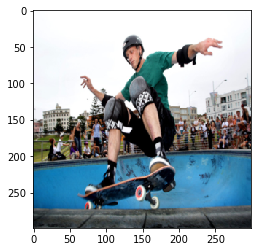

In [29]:
plt.imshow(img)

In [30]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man jumping in the air on a skateboard .
a skateboarder per@@ for@@ ming a trick on a ramp .
a skateboarder doing a trick in the air .
a man riding a skateboard down a ramp .
a man on a skateboard in the air doing a trick .
a man riding a skateboard on a ramp .
a man riding a skateboard down a ramp .
a skateboarder is doing a trick in the air .
a skateboarder is jumping over a ramp at a skate park .
a skateboarder is doing a trick in the air .


--2018-05-02 19:49:26--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 64.207.177.234
Connecting to ccanimalclinic.com (ccanimalclinic.com)|64.207.177.234|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 104.37K   272KB/s    in 0.4s    

2018-05-02 19:49:27 (272 KB/s) - ‘data/img.jpg’ saved [106870/106870]



/home/andrew/.virtualenvs/practical_dl/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


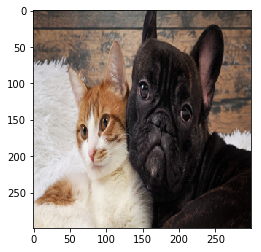

a small cat is sitting on a couch .
a close up of a cat laying on a couch
a black and white cat with a red col@@ lar .
a black and white cat is sitting on a couch
a cat is sitting on a couch with a remote contro@@ l .
a small cat is sitting on a couch .
a black and white cat is sitting on a couch
a black and white cat with a col@@ lar and a black hat .
a black and white cat with a red col@@ lar .
a black and white cat sitting on a couch .


In [32]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Find at least 10 images to test it on.
* Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
* Make sure it works okay on __simple__ images before going to something more comples
* Photos, not animation/3d/drawings, unless you want to train CNN network on anime
* Mind the aspect ratio

In [53]:
def gen_captions(url):
    !wget $url -O data/img.jpg
    img = plt.imread('data/img.jpg')
    img = imresize(img, (299, 299)).astype('float32') / 255.

    plt.imshow(img)
    plt.show()

    for i in range(10):
        print(' '.join(generate_caption(img, t=5.)[1:-1]))


--2018-05-02 20:14:57--  https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/1200px-Cat03.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156145 (152K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 152.49K  --.-KB/s    in 0.1s    

2018-05-02 20:14:58 (1.04 MB/s) - ‘data/img.jpg’ saved [156145/156145]



/home/andrew/.virtualenvs/practical_dl/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


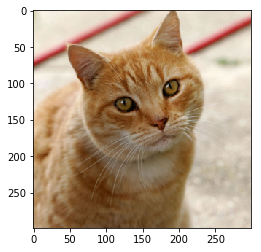

a cat is sitting on the floor of a house .
a cat sitting on a window si@@ ll looking out the window .
a cat sitting on a table looking at the camera .
a cat is sitting on the floor of a house .
a cat sitting on a window si@@ ll looking out the window .
a cat sitting on the e@@ dge of a car .
a cat is looking at a camera in a window .
a cat sitting on a window si@@ ll looking out the window .
a cat is sitting on the window si@@ ll .
a cat sitting on a table looking at the camera .


In [54]:
gen_captions("https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/1200px-Cat03.jpg")

--2018-05-02 20:21:31--  https://upload.wikimedia.org/wikipedia/commons/3/32/House_sparrow04.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 289400 (283K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 282.62K  1.50MB/s    in 0.2s    

2018-05-02 20:21:32 (1.50 MB/s) - ‘data/img.jpg’ saved [289400/289400]



/home/andrew/.virtualenvs/practical_dl/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


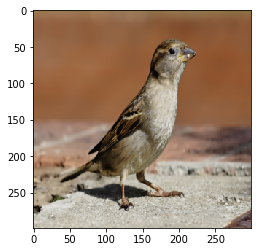

a bird that is standing on a ro@@ ck .
a small bird is standing on a ro@@ ck .
a small bird standing on a b@@ ran@@ ch in a tree .
a bird is standing on a b@@ ran@@ ch in the water .
a small bird is standing on a b@@ ran@@ ch .
a small bird standing on a b@@ ran@@ ch in a tree .
a small bird is standing on a b@@ ran@@ ch .
a small bird standing on a b@@ ran@@ ch in a tree .
a small bird standing on a ro@@ ck in the su@@ n .
a bird that is standing on a ro@@ ck .


In [62]:
gen_captions("https://upload.wikimedia.org/wikipedia/commons/3/32/House_sparrow04.jpg")

--2018-05-02 20:15:28--  http://i0.kym-cdn.com/photos/images/original/000/581/296/c09.jpg
Resolving i0.kym-cdn.com (i0.kym-cdn.com)... 8.253.99.254, 8.253.100.126, 8.253.101.126
Connecting to i0.kym-cdn.com (i0.kym-cdn.com)|8.253.99.254|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160431 (157K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 156.67K   710KB/s    in 0.2s    

2018-05-02 20:15:29 (710 KB/s) - ‘data/img.jpg’ saved [160431/160431]



/home/andrew/.virtualenvs/practical_dl/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


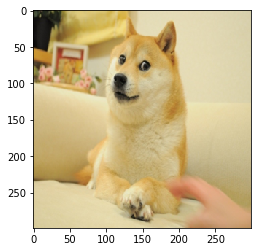

a large brown dog is sitting on a chair .
a small white and brown dog laying on a table .
a small white and brown dog laying on a car@@ p@@ et .
a small white dog with a to@@ y in its mouth .
a small brown and white dog laying on a table .
a large orange and white dog laying on a table .
a small white dog in a car@@ t with a to@@ y .
a small white dog with a to@@ y in its mouth .
a large brown dog with a to@@ y in its mouth .
a small white dog with a to@@ y in its mouth .


In [56]:
gen_captions("http://i0.kym-cdn.com/photos/images/original/000/581/296/c09.jpg")

--2018-05-02 20:12:59--  http://flashwallpapers.com/wp-content/uploads/2015/06/Little-Elephant-With-Bird-1024x768.jpeg
Resolving flashwallpapers.com (flashwallpapers.com)... 143.95.251.182
Connecting to flashwallpapers.com (flashwallpapers.com)|143.95.251.182|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 195007 (190K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 190.44K  92.0KB/s    in 2.1s    

2018-05-02 20:13:02 (92.0 KB/s) - ‘data/img.jpg’ saved [195007/195007]



/home/andrew/.virtualenvs/practical_dl/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


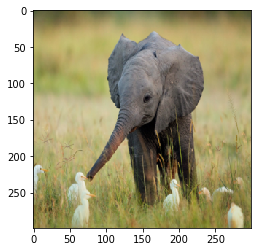

a baby elephant standing in the grass next to a tree .
a baby elephant is standing in a field .
a baby elephant is standing in the grass .
a large elephant walking through a lu@@ sh green field .
a baby elephant standing in a grassy field .
a large elephant walking through a lu@@ sh green field .
a baby elephant standing in a field of grass .
a baby elephant is standing in the grass .
a large elephant walking through a lu@@ sh green field .
a large elephant walking through a lu@@ sh green field .


In [39]:
gen_captions("http://flashwallpapers.com/wp-content/uploads/2015/06/Little-Elephant-With-Bird-1024x768.jpeg")

--2018-05-02 20:19:04--  https://pixel.nymag.com/imgs/daily/selectall/2017/02/09/09-roll-safe.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.36.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.36.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54407 (53K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  53.13K  --.-KB/s    in 0.09s   

2018-05-02 20:19:05 (562 KB/s) - ‘data/img.jpg’ saved [54407/54407]



/home/andrew/.virtualenvs/practical_dl/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


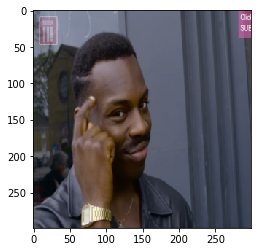

a man in a black shirt and a black tie
a man with a be@@ ard is talking on a cell phone .
a man with a tie and a shirt .
a man in a suit and tie is talking on a cell phone .
a man with a be@@ ard and a tie
a man in a black shirt and a tie
a man in a black shirt and a tie
a man in a black shirt and a black tie
a man in a black shirt and a black tie
a man in a black shirt and a tie


In [60]:
gen_captions("https://pixel.nymag.com/imgs/daily/selectall/2017/02/09/09-roll-safe.w710.h473.jpg")

--2018-05-02 20:16:52--  https://i.pinimg.com/originals/1a/54/b3/1a54b312654a19dbaeb14a9d7416c2a7.jpg
Resolving i.pinimg.com (i.pinimg.com)... 151.101.12.84, 2a04:4e42:14::84
Connecting to i.pinimg.com (i.pinimg.com)|151.101.12.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43978 (43K) [application/octet-stream]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  42.95K  --.-KB/s    in 0.1s    

2018-05-02 20:16:53 (342 KB/s) - ‘data/img.jpg’ saved [43978/43978]



/home/andrew/.virtualenvs/practical_dl/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


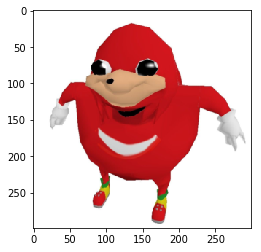

a ra@@ ck of red and white teddy bears are in a blue bag .
a ra@@ ther red teddy bear sitting on a bed .
a ra@@ ck of red and white skis on a table .
a ra@@ ck of red and white teddy bears on a table .
a ra@@ in@@ bo@@ w colored teddy bear is sitting on a bed .
a ra@@ in@@ bo@@ w colored teddy bear is sitting on a bed .
a ra@@ in@@ bo@@ w colored teddy bear is sitting on a bed .
a red teddy bear sitting in a chair with a blue bag .
a ra@@ ck of red and white skis on a table .
a ra@@ ffi@@ d@@ ra@@ t@@ e box with a pair of scisso@@ rs on it .


In [57]:
gen_captions("https://i.pinimg.com/originals/1a/54/b3/1a54b312654a19dbaeb14a9d7416c2a7.jpg")

--2018-05-02 20:20:45--  http://i0.kym-cdn.com/entries/icons/mobile/000/005/848/Aliens.jpg
Resolving i0.kym-cdn.com (i0.kym-cdn.com)... 8.253.100.126, 8.253.101.126, 8.253.99.254
Connecting to i0.kym-cdn.com (i0.kym-cdn.com)|8.253.100.126|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45254 (44K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  44.19K  --.-KB/s    in 0.1s    

2018-05-02 20:20:45 (339 KB/s) - ‘data/img.jpg’ saved [45254/45254]



/home/andrew/.virtualenvs/practical_dl/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


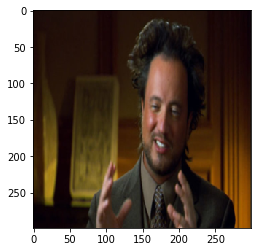

a man in a suit and tie posing for a picture .
a man in a suit and tie posing for a picture .
a man in a suit and tie posing for a picture .
a man in a suit and tie posing for a picture .
a man wearing a suit and tie holding a glass of wine .
a man in a suit and tie posing for a picture .
a man in a suit and tie standing in a room .
a man in a suit and tie posing for a picture .
a man wearing a suit and tie holding a glass of red wine .
a man in a suit and tie posing for a picture .


In [61]:
gen_captions("http://i0.kym-cdn.com/entries/icons/mobile/000/005/848/Aliens.jpg")

--2018-05-02 20:27:45--  https://img.purch.com/w/660/aHR0cDovL3d3dy5saXZlc2NpZW5jZS5jb20vaW1hZ2VzL2kvMDAwLzA5MS8wOTUvb3JpZ2luYWwvY2F0LWFuZC1kb2cuanBn
Resolving img.purch.com (img.purch.com)... 104.122.243.22
Connecting to img.purch.com (img.purch.com)|104.122.243.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47707 (47K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  46.59K  --.-KB/s    in 0.07s   

2018-05-02 20:27:46 (627 KB/s) - ‘data/img.jpg’ saved [47707/47707]



/home/andrew/.virtualenvs/practical_dl/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


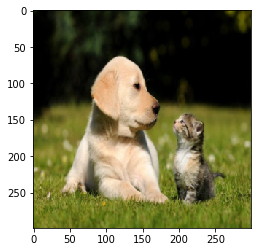

a dog laying on the ground with a frisbee in its mouth .
a dog is laying down with a frisbee in its mouth .
a dog laying on the ground with a frisbee in its mouth .
a dog laying on the ground with a frisbee in its mouth .
a dog laying on the ground with a frisbee in its mouth .
a dog laying on the ground with a frisbee in its mouth .
a dog laying on the ground next to a fire hydrant .
a dog is laying down in the grass .
a dog laying on the ground next to a frisbee .
a dog laying on the ground next to a red frisbee .


In [64]:
gen_captions("https://img.purch.com/w/660/aHR0cDovL3d3dy5saXZlc2NpZW5jZS5jb20vaW1hZ2VzL2kvMDAwLzA5MS8wOTUvb3JpZ2luYWwvY2F0LWFuZC1kb2cuanBn")

--2018-05-02 20:31:17--  https://lh3.googleusercontent.com/9GDlRvWgaW9VqrF0eX6zMinoAsuCs5TBz2jH_1WMPpV7BadHVbGYNdgcbGX0kRpFftvBTYKNjLj7x9dURL2HgAfXrnmUjrZV_pe0sOk8x1n5aFoH05CVgTf4JLZNngmx383t_HcmpRM0F1OxerMZsVQjIF4aD6vZjN0e8eeD3DW5qqeUMbAneFPWdG05b59TT00ho0mh-vg6pTNk9c7aSUZ0gvs1pamKD9l6AFKjoAjOX3hfAnGIjc6AJ6lq5GPxqOLYR4LK0tXJ9D-prfZVB35CeY_SFhXAO1XSutVIgWBFF2MvjAyFylVMX5Zzb4epLFeFOdRe_0b7aOTwDDHbyyuNRGpCQCrzgc5r1H1PplHIZ_Mbc3kPRATm0VuWYZ5SeeiZAzHXUvpl24FQwM9ktRW5Pm-eUr8fwRBgpUNIs5a_yt7JEGTx7gcHqjJiZJckAkj9G0qIFy0utBh_epyKVVzEwYAXl2B2PM2xqH98KIU78Ske5kDvUm-bl6-irn3S58qRl_yGECSSY8rxda8z2jtGap8nNPxfW_ARcO2rA1Np9oeE2VuFrA99qzHXvN-TMPnAzgEs6K7D33UyPbnxB1Ux5ZXGgl0ASvMIa-Q=w1758-h1318-no
Resolving lh3.googleusercontent.com (lh3.googleusercontent.com)... 64.233.161.132, 2a00:1450:4010:c0d::84
Connecting to lh3.googleusercontent.com (lh3.googleusercontent.com)|64.233.161.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 309592 (302K) [image/jpeg]
Saving to: ‘data/img

/home/andrew/.virtualenvs/practical_dl/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


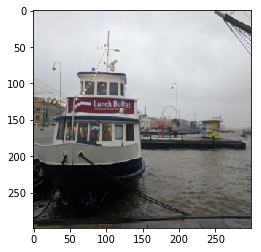

a boat is in the water with a large boat in the background .
a boat is in the water with a large crowd of people .
a boat is in the water near a bri@@ dge .
a boat is in the water with a large boat in the background .
a boat is in the water with a large boat in the background .
a boat is in the water near a bri@@ dge .
a boat is in the water with a large boat in the background .
a boat is in the water with a large boat in the background .
a large boat is in the water near the shor@@ e .
a small boat is in the water with a large boat .


In [65]:
gen_captions("https://lh3.googleusercontent.com/9GDlRvWgaW9VqrF0eX6zMinoAsuCs5TBz2jH_1WMPpV7BadHVbGYNdgcbGX0kRpFftvBTYKNjLj7x9dURL2HgAfXrnmUjrZV_pe0sOk8x1n5aFoH05CVgTf4JLZNngmx383t_HcmpRM0F1OxerMZsVQjIF4aD6vZjN0e8eeD3DW5qqeUMbAneFPWdG05b59TT00ho0mh-vg6pTNk9c7aSUZ0gvs1pamKD9l6AFKjoAjOX3hfAnGIjc6AJ6lq5GPxqOLYR4LK0tXJ9D-prfZVB35CeY_SFhXAO1XSutVIgWBFF2MvjAyFylVMX5Zzb4epLFeFOdRe_0b7aOTwDDHbyyuNRGpCQCrzgc5r1H1PplHIZ_Mbc3kPRATm0VuWYZ5SeeiZAzHXUvpl24FQwM9ktRW5Pm-eUr8fwRBgpUNIs5a_yt7JEGTx7gcHqjJiZJckAkj9G0qIFy0utBh_epyKVVzEwYAXl2B2PM2xqH98KIU78Ske5kDvUm-bl6-irn3S58qRl_yGECSSY8rxda8z2jtGap8nNPxfW_ARcO2rA1Np9oeE2VuFrA99qzHXvN-TMPnAzgEs6K7D33UyPbnxB1Ux5ZXGgl0ASvMIa-Q=w1758-h1318-no")

--2018-05-02 20:31:42--  https://lh3.googleusercontent.com/M0owUW7dW8TWGoawZDJi2KsTe1Vf29jsGhCZbh7l3lEg9zhhf9KzTnENbJbUy95DA2qrunUBxHvL6BRnxwx_qHNFmVKcB2PONhSGpHg5e7tREq73RBTTGchmIqk0DedC7KaIml2pJhZhwGoPYW-6c3wQ4AC_0nUPtxYvqAqzytY42GG3BQiixQuWmGhAJvTYQOnc6Y-qcPH_KRNqjNo5Ob6q5OgX-LUUt7Xbnyb_uPWLMhsf6HLnPdTDfu8i7rVPxl0JaBVh9IIdt22ktTKs3SoauPdgWO3k2tHiqybFFTrmI1A-cnkvdSTEx_Wuhzwgs83Skj7WRI9ftzMxYtMw-cEoTNivmacSx8sjf_GkLYMfQ54rGFeOV_HRs8V5SKVn3YOitSALPIwKeuS6Mc5d-uL0HUGak8Ci_RExAPwxrd7dsDuE_SkdU2km-Q66HwNrWBRVR0IJ9eAOSUxHN_J1dztT2hZ_dMcGlp9tqs8h23xDLmhN-_Qi1MXc--b35v_IuIc0MooNUrcRccrJ1PFkwZK9afxZ_jUDaFfyP9A8ZRyGN9m-pAR7kfkN_hh2fnpABORLRLBB_AHCDnPH7h9-WkQdskxvd1MJCVK5-Ds=w1758-h1318-no
Resolving lh3.googleusercontent.com (lh3.googleusercontent.com)... 64.233.161.132, 2a00:1450:4010:c0d::84
Connecting to lh3.googleusercontent.com (lh3.googleusercontent.com)|64.233.161.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 733860 (717K) [image/jpeg]
Saving to: ‘data/img

/home/andrew/.virtualenvs/practical_dl/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


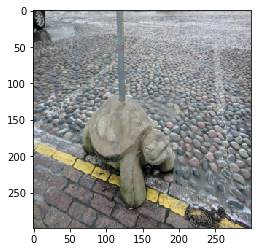

a fire hydrant is in the middle of a sidewalk .
a fire hydrant in the middle of a road .
a fire hydrant is sitting on a sidewalk .
a fire hydrant is sitting on a sidewalk .
a fire hydrant in the middle of a sidewalk .
a fire hydrant is standing on a sidewalk .
a fire hydrant is pain@@ ted with the wor@@ ds " ti@@ me . "
a fire hydrant is sitting on the side of the road .
a fire hydrant is sitting in the middle of the street .
a fire hydrant in the middle of a sidewalk .


In [66]:
gen_captions("https://lh3.googleusercontent.com/M0owUW7dW8TWGoawZDJi2KsTe1Vf29jsGhCZbh7l3lEg9zhhf9KzTnENbJbUy95DA2qrunUBxHvL6BRnxwx_qHNFmVKcB2PONhSGpHg5e7tREq73RBTTGchmIqk0DedC7KaIml2pJhZhwGoPYW-6c3wQ4AC_0nUPtxYvqAqzytY42GG3BQiixQuWmGhAJvTYQOnc6Y-qcPH_KRNqjNo5Ob6q5OgX-LUUt7Xbnyb_uPWLMhsf6HLnPdTDfu8i7rVPxl0JaBVh9IIdt22ktTKs3SoauPdgWO3k2tHiqybFFTrmI1A-cnkvdSTEx_Wuhzwgs83Skj7WRI9ftzMxYtMw-cEoTNivmacSx8sjf_GkLYMfQ54rGFeOV_HRs8V5SKVn3YOitSALPIwKeuS6Mc5d-uL0HUGak8Ci_RExAPwxrd7dsDuE_SkdU2km-Q66HwNrWBRVR0IJ9eAOSUxHN_J1dztT2hZ_dMcGlp9tqs8h23xDLmhN-_Qi1MXc--b35v_IuIc0MooNUrcRccrJ1PFkwZK9afxZ_jUDaFfyP9A8ZRyGN9m-pAR7kfkN_hh2fnpABORLRLBB_AHCDnPH7h9-WkQdskxvd1MJCVK5-Ds=w1758-h1318-no")

--2018-05-02 20:34:48--  https://lh3.googleusercontent.com/69YapORSW9g4Huuu4AE2v__y8Jv2MkOzIiOzAzXayiVKBsvnI7Ii1M5F-KxW07-ThIXlnqGQSQvUBJK6XUcJq9XCR-vOXBNd40xVGdVhm_fIb6b0PFRP94EGT29F85TtAkSvtEZOks-o8uUTah95d40Q5t0egfB-TQZSuFis7GRlWExxl9JXfIR1mmTnneE1q2PXVjMxZ9-AIMbOZIgCEZf4jfK9x9P3p8UqNFLFXiIVu7IgRHHe31ukW0KUaTQs5w1jdLgme1FOOcsnQrXa0nugdn_plietb8PNkP1ShzyRFgr9L5l5AkJzdW2NWP6Vk4cQwLA1hi3GzEcQArmwQS9Mt1fdTkZ2WSVZUltvYAOwxtO0SWm8uJnjdo2WICFFZsgWTyFf4R_chDj9VTAfDDHjrxhAyh9SBuxlUXxmpisCS2THhj5YcPkFqk5xUqtPFi9zuh--CZiUPNcC7dK-NGb5LUB7lbKlgOl4XqJiphUcwqLEM1hDkErk-0Y6vgF0nciz-0B9tf4C-cg0iTt1ZO3zl1WrGOAaK6IplmgIG7FdXrQE-DrQDy-WOZeRAPMN1OXH_RCe92I6yR8_JAudaaIvKIKdMX396jfv2NA=w1758-h1318-no
Resolving lh3.googleusercontent.com (lh3.googleusercontent.com)... 173.194.73.132, 2a00:1450:4010:c0d::84
Connecting to lh3.googleusercontent.com (lh3.googleusercontent.com)|173.194.73.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 847651 (828K) [image/jpeg]
Saving to: ‘data/img

/home/andrew/.virtualenvs/practical_dl/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


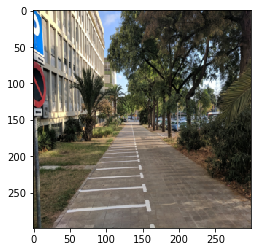

a sign that sa@@ ys n@@ o parking on the side of the road .
a street sign on a pole on a city street
a street sign at a street corner with a sign in the background .
a street sign on a pole on a city street
a sign that sa@@ ys " do@@ n@@ '@@ t stop b@@ el@@ i@@ e@@ ve " on the side of the road .
a street sign on a pole on a city street
a street sign on a pole on a city street
a sign that is on the side of a road .
a street sign on the side of a road .
a street sign on a pole on a city street


In [68]:
gen_captions("https://lh3.googleusercontent.com/69YapORSW9g4Huuu4AE2v__y8Jv2MkOzIiOzAzXayiVKBsvnI7Ii1M5F-KxW07-ThIXlnqGQSQvUBJK6XUcJq9XCR-vOXBNd40xVGdVhm_fIb6b0PFRP94EGT29F85TtAkSvtEZOks-o8uUTah95d40Q5t0egfB-TQZSuFis7GRlWExxl9JXfIR1mmTnneE1q2PXVjMxZ9-AIMbOZIgCEZf4jfK9x9P3p8UqNFLFXiIVu7IgRHHe31ukW0KUaTQs5w1jdLgme1FOOcsnQrXa0nugdn_plietb8PNkP1ShzyRFgr9L5l5AkJzdW2NWP6Vk4cQwLA1hi3GzEcQArmwQS9Mt1fdTkZ2WSVZUltvYAOwxtO0SWm8uJnjdo2WICFFZsgWTyFf4R_chDj9VTAfDDHjrxhAyh9SBuxlUXxmpisCS2THhj5YcPkFqk5xUqtPFi9zuh--CZiUPNcC7dK-NGb5LUB7lbKlgOl4XqJiphUcwqLEM1hDkErk-0Y6vgF0nciz-0B9tf4C-cg0iTt1ZO3zl1WrGOAaK6IplmgIG7FdXrQE-DrQDy-WOZeRAPMN1OXH_RCe92I6yR8_JAudaaIvKIKdMX396jfv2NA=w1758-h1318-no")

### Now what?

Your model produces some captions but you still strive to improve it? You're damn right to do so. Here are some ideas that go beyond simply "stacking more layers". The options are listed easiest to hardest.

##### Subword level captioning
In the base version, we replace all rare words with UNKs which throws away a lot of information and reduces quality. A better way to deal with vocabulary size problem would be to use Byte-Pair Encoding

* BPE implementation you can use: [github_repo](https://github.com/rsennrich/subword-nmt). 
* Theory: https://arxiv.org/abs/1508.07909
* It was originally built for machine translation, but it should work with captioning just as well.

##### Attention
You can build better and more interpretable captioning model with attention.
* How it works: https://distill.pub/2016/augmented-rnns/
* One way of doing this in captioning: https://arxiv.org/abs/1502.03044
* You will have to create a dataset for attention with [this notebook](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

#### Reinforcement learning
* After your model has been pre-trained in a teacher forced way, you can tune for captioning-speific models like CIDEr.
* Tutorial on RL for sequence models: [practical_rl week8](https://github.com/yandexdataschool/Practical_RL/tree/master/week8_scst)
* Theory: https://arxiv.org/abs/1612.00563

# Report

To be able to compare different models, we need to establish validation procedure that will be independent of selected token types (BPE vs words) and overfitting ability of selected metric (cross entropy is prone to overfitting even on validation dataset, thus, reducation is validation cross entropy may not correspond with prediction quality). World-level BLEU metric was selected to compare different models. To accomodate for different tokens in BPE, we used the following preprocessing before calculation BLEU score:

```
str.replace("@@ ", "")
```
Here is the final results:

* Baseline validation BLEU: 0.285
* BPE validation BLEU: 0.289
* GRU + BPE validation BLEU: 0.280
* LSTM + BPE hidden=256 validation BLEU: 0.286